## import 套件

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import os
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.np_utils import to_categorical 
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import itertools

Using TensorFlow backend.


## 訓練資料處理

In [2]:
w = 256
h = 256*256
file_count = 0
for floderName in os.listdir(r"//data/examples/may_the_4_be_with_u/where_am_i/train/"):
    for filename in os.listdir(r"//data/examples/may_the_4_be_with_u/where_am_i/train/" + floderName):
        file_count +=1

print(file_count)
label = np.zeros(shape=[file_count])
images = np.zeros(shape=[file_count,w,w,3])
file_count = 0
        
for floderName in os.listdir(r"//data/examples/may_the_4_be_with_u/where_am_i/train/"):
    for filename in os.listdir(r"//data/examples/may_the_4_be_with_u/where_am_i/train/" + floderName):        
            
        temp = cv2.imread("//data/examples/may_the_4_be_with_u/where_am_i/train/" + floderName + "/" + filename)
        temp = cv2.resize(temp, (w,w),interpolation=cv2.INTER_CUBIC)
        images[file_count] = temp
        
        if floderName == "bedroom":
            label[file_count] = 12
        elif floderName == "CALsuburb":
            label[file_count] = 9
        elif floderName == "coast":
            label[file_count] = 10
        elif floderName == "forest":
            label[file_count] = 4
        elif floderName == "highway":
            label[file_count] = 14
        elif floderName == "industrial":
            label[file_count] = 2
        elif floderName == "insidecity":
            label[file_count] = 3
        elif floderName == "kitchen":
            label[file_count] = 0
        elif floderName == "livingroom":
            label[file_count] = 5
        elif floderName == "mountain":
            label[file_count] = 8
        elif floderName == "opencountry":
            label[file_count] = 6
        elif floderName == "PARoffice":
            label[file_count] = 7
        elif floderName == "store":
            label[file_count] = 11
        elif floderName == "street":
            label[file_count] = 1
        elif floderName == "tallbuilding":
            label[file_count] = 13
        
        file_count += 1

2985


### Show Image

7.0
<class 'numpy.float64'>


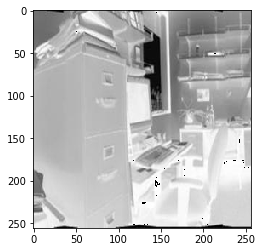

In [3]:
#image = cv2.imread("./Data/train/bedroom/image_0001.jpg", cv2.IMREAD_GRAYSCALE)
#cv2.imshow("image",image)
print(label[220]), print(type(label[220])) #bedroom的label=9
plt.imshow(images[220])


## 測試資料處理

### 從img-submission.csv檔中抓出所有圖片對應的檔名

In [4]:
import pandas as pd
pd.set_option('max_colwidth',200) #修改pandas顯示字數的上限
df = pd.read_csv('//data/examples/may_the_4_be_with_u/where_am_i/img-submission.csv') #submission檔內有每個圖片的檔名
len(df) #看看有幾筆

1500

### print出隨意五筆看看

In [5]:
df.sample(5)

,id,class
881,4a6a3cb72211ff998a697b7b2e263a6d740add1b3e6ce4569bb33104b3a5f95e,1
1328,e2a5802b20da9eec7053995c03e705478e7bdb9278941cfa63369db9933750b5,1
186,28ecb6d20e4c9e19f08ef768ddbfede221ab67cfb5e677886068728bfde6a232,1
384,1d0dede8a5c5f5be22cc52fc9d23f23c84bde32058c3aa5012fd3dbe6c88ba5d,1
37,81f4a1aa46ea4efdb4fed3ffe00529cf02fb9a93b15f52ba8cc36f2bc29e54b8,1


### 取出作為檔名的id列

In [6]:
list_end=df.id.as_matrix().tolist()

### 迴圈加上副檔名並把圖片加入陣列

In [7]:
test_img = np.zeros(shape=[1500,w,w,3])
count = 0
for i in list_end:
    img=cv2.imread('//data/examples/may_the_4_be_with_u/where_am_i/testset/'+ i +'.jpg')
    img=cv2.resize(img,(w,w)) 
    test_img[count] = img
    count += 1

### Shape

In [8]:
test_img.shape , images.shape 

((1500, 256, 256, 3), (2985, 256, 256, 3))

### Show Image

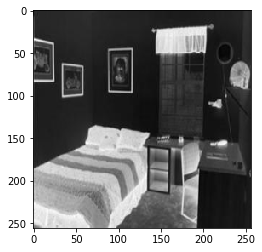

In [9]:
plt.imshow(test_img[0])

## 圖片預處理

In [10]:
images=images.reshape(2985,w,w,3).astype('float32')
test_img=test_img.reshape(1500,w,w,3).astype('float32')  

In [11]:
images.ndim,test_img.ndim #查看維度

(4, 4)

In [12]:
x_train_normalize=images/255     #訓練集正規化
x_test_normalize=test_img/255    #測試集正規化
x_train_normalize[0]             #正規化之訓練集第一張圖片

array([[[ 0.1882353 ,  0.1882353 ,  0.1882353 ],
        [ 0.1882353 ,  0.1882353 ,  0.1882353 ],
        [ 0.1882353 ,  0.1882353 ,  0.1882353 ],
        ..., 
        [ 0.49019608,  0.49019608,  0.49019608],
        [ 0.45882353,  0.45882353,  0.45882353],
        [ 0.3764706 ,  0.3764706 ,  0.3764706 ]],

       [[ 0.1882353 ,  0.1882353 ,  0.1882353 ],
        [ 0.1882353 ,  0.1882353 ,  0.1882353 ],
        [ 0.1882353 ,  0.1882353 ,  0.1882353 ],
        ..., 
        [ 0.47843137,  0.47843137,  0.47843137],
        [ 0.4627451 ,  0.4627451 ,  0.4627451 ],
        [ 0.39607844,  0.39607844,  0.39607844]],

       [[ 0.1882353 ,  0.1882353 ,  0.1882353 ],
        [ 0.1882353 ,  0.1882353 ,  0.1882353 ],
        [ 0.1882353 ,  0.1882353 ,  0.1882353 ],
        ..., 
        [ 0.47058824,  0.47058824,  0.47058824],
        [ 0.47058824,  0.47058824,  0.47058824],
        [ 0.40392157,  0.40392157,  0.40392157]],

       ..., 
       [[ 0.3019608 ,  0.3019608 ,  0.3019608 ],
        

## 標籤預處理

In [13]:
label

array([  9.,   9.,   9., ...,  13.,  13.,  13.])

In [14]:
label[0],print(type(label[0]))

<class 'numpy.float64'>


(9.0, None)

### label做One Hot Encoding

In [15]:
from keras.utils import np_utils
y_train_onehot=np_utils.to_categorical(label)   #訓練集標籤
y_train_onehot[0],y_train_onehot.ndim

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.]), 2)

## 把訓練集分割成test和train

In [16]:
from sklearn.cross_validation import train_test_split
X, y = x_train_normalize, y_train_onehot
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.1, random_state=42)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2686, 256, 256, 3), (299, 256, 256, 3), (2686, 15), (299, 15))

In [18]:
X_train.ndim, X_test.ndim, y_train.ndim, y_test.ndim

(4, 4, 2, 2)

In [19]:
base_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(256, 256, 3))#載入預訓練模組，設定自訂圖片大小(預設為299*299)
x = base_model.output           #添加全域空間的平均池化層
x = GlobalAveragePooling2D()(x) #
predictions = Dense(15, activation='softmax')(x) #建立回歸模型，15種類別應用Softmax回歸模型
model = Model(base_model.input, predictions)     #架構結合
print(model.summary())                           #顯示模型結構

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

## 進行訓練

In [20]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,            # 布林值。將輸入數據的均值設置為0，逐特徵進行。
    samplewise_center=False,             # 布林值。將每個樣本的均值設置為0。
    featurewise_std_normalization=False, # 布林值。將輸入除以數據標準差，逐特徵進行。
    samplewise_std_normalization=False,  # 布林值。將每個輸入除以其標準差。
    zca_whitening=False,                 # 布林值。應用ZCA白化。
    rotation_range=20,                   # 整數。隨機旋轉的度數範圍。
    zoom_range = 0.1,                    # 浮點數或[lower，upper]。隨機縮放範圍。
    width_shift_range=0.25,              # 浮點數（總寬度的比例）。隨機水平移動的範圍。
    height_shift_range=0.25,             # 浮點數（總高度的比例）。隨機垂直移動的範圍。
    horizontal_flip=False,               # 布林值。隨機水平翻轉。
    vertical_flip=False)                 # 布林值。隨機垂直翻轉。

datagen.fit(X_train) # 計算特徵正規化所需的數量

In [21]:
model.compile(loss='categorical_crossentropy', optimizer= keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy']) #函數進行設定 

In [22]:
train_history = model.fit_generator (datagen.flow(X_train,y_train, batch_size=2),
                              epochs = 20, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // 2
                              , callbacks=[ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)])

Epoch 1/20
1343/1343 [==============================] - 65s 48ms/step - loss: 2.3371 - acc: 0.2022 - val_loss: 1.7450 - val_acc: 0.3177
Epoch 2/20
1343/1343 [==============================] - 64s 47ms/step - loss: 1.7721 - acc: 0.3690 - val_loss: 1.5056 - val_acc: 0.4515
Epoch 3/20
1343/1343 [==============================] - 64s 47ms/step - loss: 1.4867 - acc: 0.4814 - val_loss: 1.3960 - val_acc: 0.4783
Epoch 4/20
1343/1343 [==============================] - 64s 47ms/step - loss: 1.2953 - acc: 0.5428 - val_loss: 1.5437 - val_acc: 0.5151
Epoch 5/20
1343/1343 [==============================] - 64s 47ms/step - loss: 1.1559 - acc: 0.5990 - val_loss: 1.2444 - val_acc: 0.5719
Epoch 6/20
1343/1343 [==============================] - 64s 47ms/step - loss: 1.0350 - acc: 0.6467 - val_loss: 0.8806 - val_acc: 0.6923
Epoch 7/20
1343/1343 [==============================] - 63s 47ms/step - loss: 0.9427 - acc: 0.6720 - val_loss: 0.8463 - val_acc: 0.7090
Epoch 8/20
1343/1343 [==========================

### loss (訓練集損失)

In [23]:
train_history.history["loss"] 

[2.3371488097125881,
 1.7721319271061551,
 1.4867246622872925,
 1.295347332978678,
 1.1558874442700195,
 1.0349873706718908,
 0.94265909104837264,
 0.86925290488185847,
 0.82902229266199734,
 0.75896243853646761,
 0.74724657917254589,
 0.68380045997780703,
 0.61006190886807865,
 0.59452806522484947,
 0.56459205094011544,
 0.5701627928811267,
 0.51195025270852423,
 0.52421192265361471,
 0.43901931824328583,
 0.43720328414178933]

### acc (訓練集準確度)

In [24]:
train_history.history["acc"]

[0.20215934475055844,
 0.36895011169024572,
 0.48138495904690992,
 0.5428145941921072,
 0.59903201787043936,
 0.64668652271034999,
 0.67200297840655254,
 0.70439314966492927,
 0.70997766195085632,
 0.73752792256142963,
 0.73938942665673868,
 0.76098287416232313,
 0.78965003723008187,
 0.79151154132539092,
 0.80677587490692482,
 0.79151154132539092,
 0.82092330603127328,
 0.82055100521221147,
 0.84735666418466116,
 0.85443037974683544]

### val_loss (驗證集損失)

In [25]:
train_history.history["val_loss"]

[1.7450381716756915,
 1.5055646266426927,
 1.3959833485226967,
 1.5436758916847395,
 1.2444045898492095,
 0.88064686305127704,
 0.84634619208058981,
 0.93167928386678966,
 0.96472444494036136,
 0.93080914119900171,
 0.73505787683820611,
 0.73546399948649821,
 0.76885305930892278,
 0.80475589280062065,
 0.84294801445410794,
 0.86993805407583968,
 0.91634699638923112,
 0.65912757207412231,
 0.71086242363858121,
 1.0460955621372641]

### val_acc (驗證集準確度)

In [26]:
train_history.history["val_acc"]

[0.31772575250836121,
 0.451505016722408,
 0.47826086956521741,
 0.51505016722408026,
 0.57190635451505012,
 0.69230769230769229,
 0.70903010033444813,
 0.68227424749163879,
 0.66555183946488294,
 0.7123745819397993,
 0.74916387959866215,
 0.75250836120401343,
 0.74916387959866215,
 0.74581939799331098,
 0.76254180602006694,
 0.72240802675585281,
 0.66555183946488294,
 0.76923076923076927,
 0.78595317725752512,
 0.72575250836120397]

### 使用 matplotlib 函數來繪製訓練紀錄, 描繪誤差值 (loss) 與準確度 (acc) 隨 epoch 變化的情形

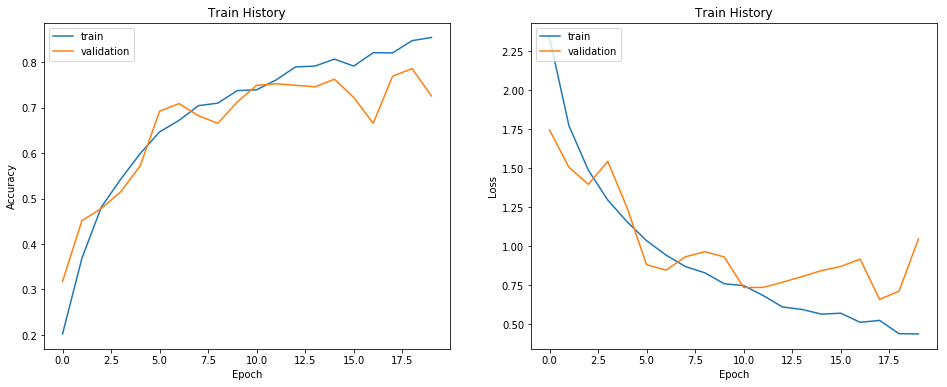

In [27]:
import matplotlib.pyplot as plt  
def show_train_history(train_history):
    fig=plt.gcf()
    fig.set_size_inches(16, 6)
    plt.subplot(121)
    plt.plot(train_history.history["acc"])
    plt.plot(train_history.history["val_acc"])
    plt.title("Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train", "validation"], loc="upper left")
    plt.subplot(122)
    plt.plot(train_history.history["loss"])
    plt.plot(train_history.history["val_loss"])
    plt.title("Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
show_train_history(train_history) 

## 評估模型準確率

In [28]:
scores=model.evaluate(X_test, y_test)    
print("Accuracy=", scores)  
print("Accuracy=", scores[1])  

299/299 [==============================] - 2s 7ms/step
Accuracy= [1.0460959856326764, 0.72575250915859058]
Accuracy= 0.725752509159


### 以測試集進行預測

In [41]:
prediction=model.predict(test_img)
print(prediction)

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   1.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  2.93275639e-23   0.00000000e+00   0.00000000e+00 ...,   2.75356006e-28
    0.00000000e+00   0.00000000e+00]
 [  9.99871731e-01   0.00000000e+00   0.00000000e+00 ...,   2.68975583e-14
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


In [42]:
prediction = np.argmax(prediction,axis = 1)

In [43]:
prediction[0],prediction[1],prediction[2],prediction[896]

(12, 14, 0, 14)

In [44]:
pred_df = pd.DataFrame(prediction, index=df["id"], columns=["class"])
pred_df.to_csv('VGG16_result.csv', header=True, index_label='id')

In [45]:
df0 = pd.read_csv('VGG16_result.csv')
df0.head(12)

,id,class
0,c117693e1cf24a5232090d1548cb11d4e5ea0df65680c4a56a8e8aa2beede330,12
1,96baacc2e97886a998807ce197574821a6dc83c227c7469961c01ab315908371,14
2,f9bd26db23eb9b544ca78be79b11b4d1259e802885861d8b66a8e709995229db,0
3,b42bcd8e6645fcc2ac40ee44b7dc8d74a77081d0aea7a1a88eaba3d8393001c3,5
4,5bc53cef9168882f0ff67a81b3e7269f62b7fd5343d06dafe63570d5032c21f3,2
5,f80823d6bff6c0beba6d55a3157d7a4fa2de4f966351e0fa7d322e5962f46ece,7
6,3a12151639cf9f8e2af9ea36c2ce6bb15dd8730ea6dc904621dd754ebd3c1155,14
7,a5e0980425df5b98864a9580e081a7209e1b6810ed515afab1617cdc62299ac1,10
8,d4ea833073c4391387bebaef3c51c22861c1ff108cbb3c52f33c0dc3c81564f0,3
9,013c78d920be5390dbc66ca238ae3f49a2b0cf13e3601331678b871fc0d4a237,8


![result](vgg16result.PNG)